In [1]:
# Imports.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, fbeta_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import pickle
import os
import seaborn as sns
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [2]:
# Setting visualization options.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Importing DF.
df = pd.read_csv("../data/dataset_credito_transacional.csv", delimiter=",")

In [4]:
# Defining targets, keys and features.
list_target =["personal_loan", 
              "mortgage",
              "auto_loan",
              "credit_card",
              "overdraft", 
              "payroll_loan",
              "student_loan",
              "working_capital_loan"]

df_targets = df[list_target]
list_primary_keys = ["person_id", "transaction_date", "name"]
df_primary_keys = df[list_primary_keys]
df_features = df.drop(columns=list_target + list_primary_keys)

In [5]:
# Creating categories from qualitative fields.
dict_education_cat = {
    'Primary': 1,
    'Secondary': 2,
    'Bachelor': 3,
    'Postgraduate': 4
}

dict_salary_cat = {
    "<30k": 1,
    "30k-50k": 2,
    "50k-80k": 3,
    "80k-120k": 4,
    ">120k": 5
}

dict_investment_cat = {
    "<1k": 1,
    "1k-10k": 2,
    "10k-50k": 3,
    ">50k": 4
}

df_features['education'] = df_features['education'].map(dict_education_cat)
df_features['annual_salary'] = df_features['annual_salary'].map(dict_salary_cat)
df_features['invested_amount'] = df_features['invested_amount'].map(dict_investment_cat)


le = LabelEncoder()
df_features['sex'] = le.fit_transform(df_features['sex'])

for col in df_features.columns:
    if "has_" in col or "ever_loan" in col or "loan_paid" in col:
        df_features[col] = le.fit_transform(df_features[col])


df_final = pd.concat([df_primary_keys, df_features, df_targets], axis=1)

In [6]:
# Dividing into train and test.
X = df_final.drop(columns=list_primary_keys + list_target)
y = df_final[list_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Train model.
lr = LogisticRegression(C=0.000009,
                        solver= 'lbfgs',
                        max_iter=10000, 
                        class_weight='balanced',
                        tol=0.001,
                        warm_start=True,
                        penalty='l2',
                        n_jobs=-1)

model = MultiOutputClassifier(lr)

model.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(C=9e-06,
                                                   class_weight='balanced',
                                                   max_iter=10000, n_jobs=-1,
                                                   tol=0.001, warm_start=True))

In [8]:
# Obtaining probabiity.
y_pred = model.predict(X_test)

# Storing into a dictionary.
y_proba = model.predict_proba(X_test)
dict_probas = dict()
for target, proba in zip(list_target, y_proba):
    dict_probas[target] = proba[:, 1]

# Create df.
df_probas_pos = pd.DataFrame(dict_probas)

# Describe.
df_probas_pos.describe()

,personal_loan,mortgage,auto_loan,credit_card,overdraft,payroll_loan,student_loan,working_capital_loan
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,0.502473,0.508399,0.499061,0.500605,0.498636,0.496663,0.494483,0.492076
std,0.039105,0.065625,0.045852,0.032366,0.020477,0.027391,0.046661,0.060769
min,0.415705,0.357422,0.421115,0.426321,0.452513,0.444801,0.392438,0.383744
25%,0.473724,0.459764,0.463787,0.477270,0.484993,0.476512,0.456304,0.442150
50%,0.501391,0.506515,0.497132,0.499803,0.499956,0.496625,0.494636,0.495616
75%,0.530732,0.555438,0.529748,0.523747,0.514511,0.515940,0.530634,0.535395
max,0.611081,0.682230,0.601582,0.587033,0.533918,0.555556,0.606630,0.651094


Target: personal_loan        | Best Threshold: 0.4462 | F-Score: 0.766
Target: mortgage             | Best Threshold: 0.4377 | F-Score: 0.804
Target: auto_loan            | Best Threshold: 0.4589 | F-Score: 0.672
Target: credit_card          | Best Threshold: 0.4268 | F-Score: 0.728
Target: overdraft            | Best Threshold: 0.4756 | F-Score: 0.421
Target: payroll_loan         | Best Threshold: 0.4790 | F-Score: 0.459
Target: student_loan         | Best Threshold: 0.5276 | F-Score: 0.172
Target: working_capital_loan | Best Threshold: 0.4764 | F-Score: 0.624


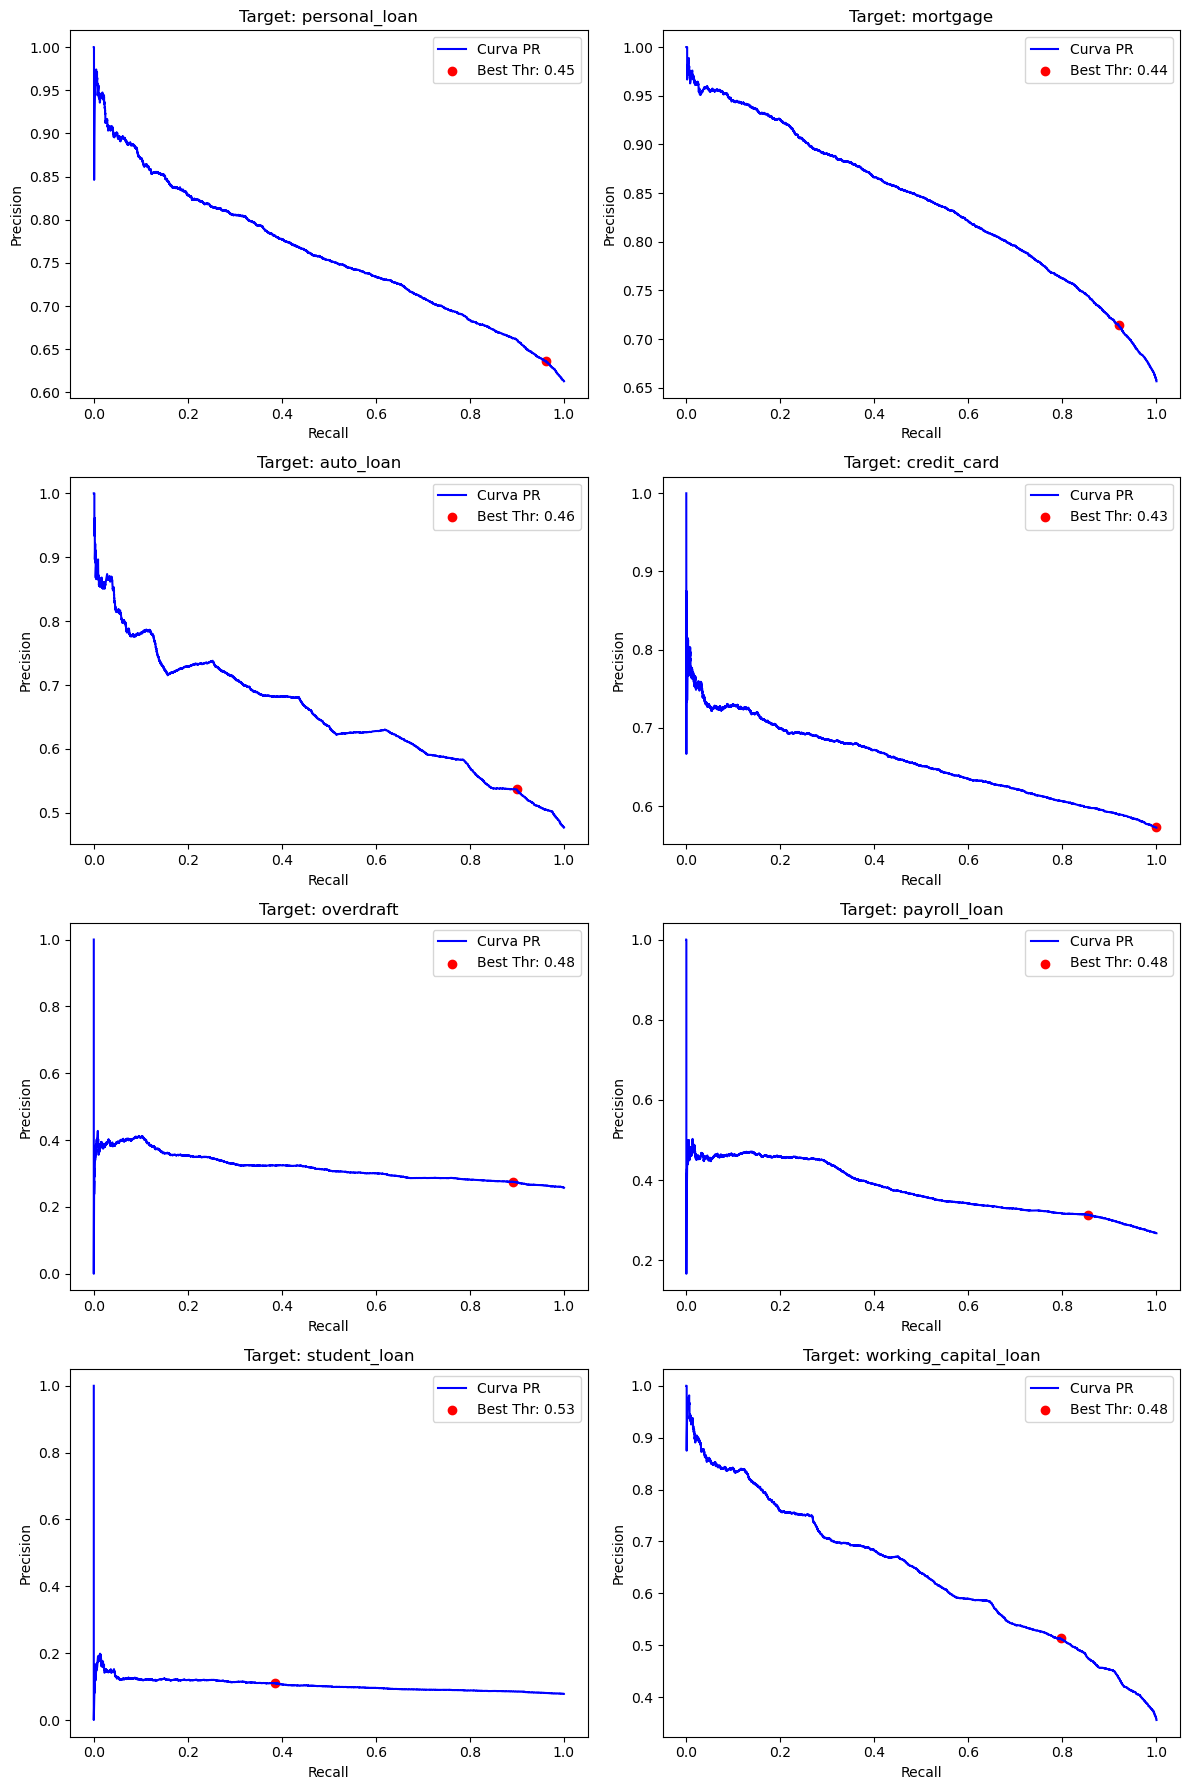

In [9]:
# Configuring grid for chart.
fig, axes = plt.subplots(4, 2, figsize=(12, 18))
axes = axes.ravel() 

# Create dict for thresholds.
best_thresholds = dict()

for i, target in enumerate(list_target):
    precision, recall, thresholds = precision_recall_curve(y_test[target], dict_probas[target])
    
    # Calculating F2 for each threshold (better for recall!!)
    f2_score = (5 * precision * recall) / (4 * precision + recall + 1e-9)
    f1_scores_array = (2 * precision * recall) / (precision + recall + 1e-9)

    ix = np.argmax(f1_scores_array)
    
    best_thr = thresholds[ix]
    best_thresholds[target] = best_thr
    
    print(f'Target: {target:20} | Best Threshold: {best_thr:.4f} | F-Score: {f1_scores_array[ix]:.3f}')
    
    ax = axes[i]
    ax.plot(recall, precision, color='blue', label='Curva PR')
    ax.scatter(recall[ix], precision[ix], marker='o', color='red', label=f'Best Thr: {best_thr:.2f}')
    ax.set_title(f'Target: {target}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()

plt.tight_layout()
plt.show()

In [10]:
# Create custom list.
preds_list = []
performance_metrics = []

for target in list_target:
    target_preds = (dict_probas[target] >= best_thresholds[target]).astype(int)
    preds_list.append(target_preds)

y_pred_custom = np.column_stack(preds_list)

# Iterating in 8 targets.
for i, target_name in enumerate(list_target):

    y_true_target = y_test[target_name]
    
    y_pred_target = y_pred_custom[:, i]
    
    y_proba_target = dict_probas[target_name]
    
    metrics = {
        "Target": target_name,
        "Accuracy": accuracy_score(y_true_target, y_pred_target),
        "Precision": precision_score(y_true_target, y_pred_target, zero_division=0),
        "Recall": recall_score(y_true_target, y_pred_target, zero_division=0),
        "F1": f1_score(y_true_target, y_pred_target, zero_division=0),
        "F2": fbeta_score(y_true_target, y_pred_target, beta=2, zero_division=0),
        "AUC": roc_auc_score(y_true_target, y_proba_target)
    }
    performance_metrics.append(metrics)

# Final Dataframe.
df_metrics = pd.DataFrame(performance_metrics)

# Print.
print(df_metrics.to_string(index=False, formatters={
    'Accuracy': '{:,.4f}'.format,
    'Precision': '{:,.4f}'.format,
    'Recall': '{:,.4f}'.format,
    'F1': '{:,.4f}'.format,
    'F2': '{:,.4f}'.format,
    'AUC': '{:,.4f}'.format
}))

              Target Accuracy Precision Recall     F1     F2    AUC
       personal_loan   0.6391    0.6358 0.9625 0.7658 0.8728 0.6770
            mortgage   0.7055    0.7141 0.9199 0.8040 0.8697 0.7409
           auto_loan   0.5818    0.5369 0.8992 0.6724 0.7923 0.6861
         credit_card   0.5727    0.5726 1.0000 0.7282 0.8701 0.5986
           overdraft   0.3684    0.2754 0.8917 0.4208 0.6159 0.5818
        payroll_loan   0.4618    0.3143 0.8533 0.4594 0.6354 0.6358
        student_loan   0.7077    0.1104 0.3861 0.1717 0.2575 0.5855
working_capital_loan   0.6585    0.5131 0.7960 0.6240 0.7170 0.7600


In [11]:
# Calculating coefficients.
coefficients = [estimator.coef_ for estimator in model.estimators_]
intercept = [float(estimator.intercept_) for estimator in model.estimators_]

# Creating dataframe.
df_coefs = pd.DataFrame([array[0] for array in coefficients], columns=[df_features.columns], index=list_target)

# Adding intercept.
df_coefs["intercept"] = intercept
col_order =  ["intercept"] + [col for col in df_features.columns]
df_coefs = df_coefs[col_order]

C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_17060\28390454.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercept = [float(estimator.intercept_) for estimator in model.estimators_]


In [12]:
# Save.
with open (r"../models/trained_model-0.1.0.pkl", "wb") as f:
    pickle.dump(model, f)